## Calculating trial-wise parametric modulations

This script calculates values of model variables like value estimation or prediction error for each trial. Script features:
- loads point estimations of model parameters (e.g. learning rates)
- calculates trial-wise estimates of different model tracking variables (e.g. prediction error)
- saves these parametric modulations to file

(*Note*) Usually subjects are trying to minimize overal prediction error. Here it is not precisely the case, because sometimes subject pick probabilistically worse option to maximize their winnings.

---
**Last update**: 06.02.2020 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import sys
import os

path_root = os.environ.get('DECIDENET_PATH')
if path_root is None:
    raise Exception('Please specify path to the project folder as ' \
                   +'environment variable $DECIDENET_PATH')
path_code = os.path.join(path_root, 'code')
if path_code not in sys.path:
    sys.path.append(path_code)

from dn_utils.behavioral_models import (load_behavioral_data, 
    estimate_wbci_pd, estimate_modulation)
from dn_utils.plotting import plot_trial_modulation

In [2]:
# Directory to save modulations
path_out = os.path.join(path_root, 'data/main_fmri_study/derivatives/nistats/modulations')

# Load data
path_beh = os.path.join(path_root, 'data/main_fmri_study/sourcedata/behavioral')
path_param = os.path.join(path_code, 'behavioral_analysis/matjags-dn/data/' + \
                                     'subjects_point_estimates/alpha_pdci_mle.npy')

beh, meta = load_behavioral_data(path_beh)
alpha_pdci_mle = np.load(path_param)

n_subjects = len(meta['dim1'])
n_conditions = len(meta['dim2'])
n_trials = len(meta['dim3'])

Shape of beh array: (32, 2, 110, 23)
Conditions [(0, 'rew'), (1, 'pun')]
Columns: [(0, 'block'), (1, 'block_bci'), (2, 'side'), (3, 'side_bci'), (4, 'magn_left'), (5, 'magn_right'), (6, 'response'), (7, 'rt'), (8, 'won_bool'), (9, 'won_magn'), (10, 'acc_after_trial'), (11, 'onset_iti'), (12, 'onset_iti_plan'), (13, 'onset_iti_glob'), (14, 'onset_dec'), (15, 'onset_dec_plan'), (16, 'onset_dec_glob'), (17, 'onset_isi'), (18, 'onset_isi_plan'), (19, 'onset_isi_glob'), (20, 'onset_out'), (21, 'onset_out_plan'), (22, 'onset_out_glob')]


### Calculate and save parametric modulations.
Here parametric modulations reflecting three relevant model variables are calculated:
- `modulation_wcor`: parametric modulation during choice phase reflecting estimated probability of choosing correct (winning / not loosing) box
- `modulation_exvl`: parametric modulation during choice phase reflecting Pascalian expected value
- `modulation_perr`: parametric modulation during outcome phase reflecting prediction error on box probability 
    - equals `1 - wcor` for correct anwers
    - equals `0 - wcor` for incorrect answers

In [3]:
modulation_wcor = np.zeros((n_subjects, n_conditions, n_trials))
modulation_exvl = np.zeros((n_subjects, n_conditions, n_trials))
modulation_perr = np.zeros((n_subjects, n_conditions, n_trials))

for sub in range(n_subjects):
    for con in range(n_conditions):
        
        wbci = estimate_wbci_pd(
            beh, meta, sub, con,
            alpha_plus=alpha_pdci_mle[sub, 0], 
            alpha_minus=alpha_pdci_mle[sub, 1]
        )
        
        wcor, exvl, perr = estimate_modulation(beh, meta, sub, con, wbci)
        
        modulation_wcor[sub, con, :] = wcor
        modulation_exvl[sub, con, :] = exvl
        modulation_perr[sub, con, :] = perr

np.save(os.path.join(path_out,'modulation_wcor'), modulation_wcor)
np.save(os.path.join(path_out,'modulation_exvl'), modulation_exvl)
np.save(os.path.join(path_out,'modulation_perr'), modulation_perr)

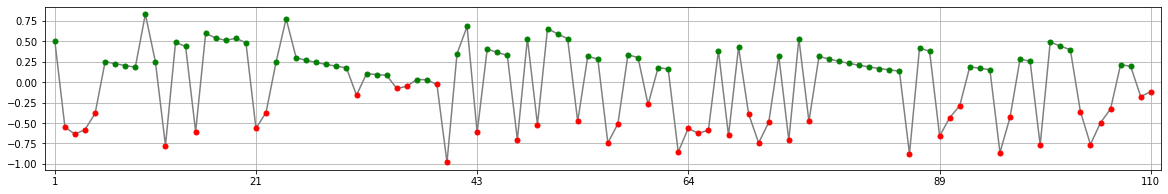

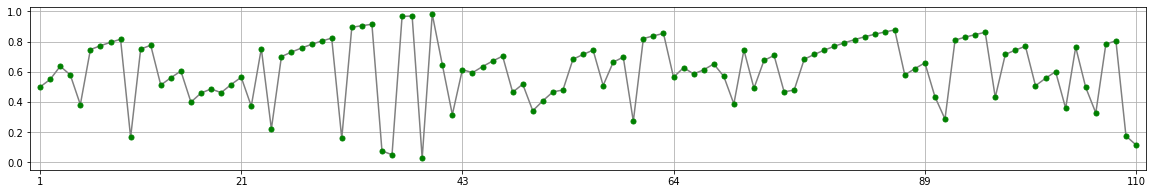

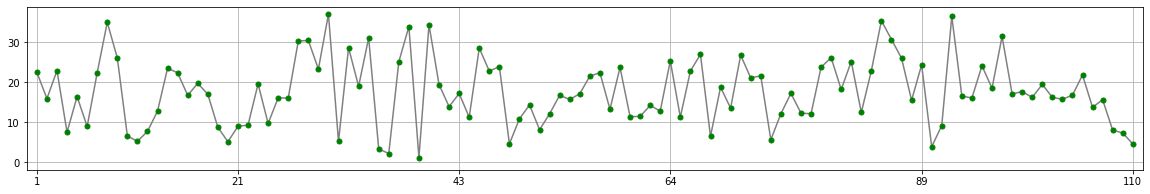

In [4]:
# Plot example regressors
sub, con = 1, 0

plot_trial_modulation(beh, meta, sub, con, modulation_perr[sub, con, :])
plot_trial_modulation(beh, meta, sub, con, modulation_wcor[sub, con, :])
plot_trial_modulation(beh, meta, sub, con, modulation_exvl[sub, con, :])